In [1]:
import glob
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import sys

sys.path.append("../")
import analysis_util, tasks, ragged_task_evolution, general_network_visualization

In [3]:
and_dir = "boolean_network_data/and_evolution_results/2023-03-13-21-10-14"
xor_dir = "boolean_network_data/xor_evolution_results/2023-03-13-21-10-20"

In [4]:
def load_data(path):
    timestamps = []
    losses = []
    functions = []
    connectivity = []
    used_connectivity = []
    for file in glob.glob(os.path.join(path, "*.npz")):
        try:
            data = np.load(file)
            if data["timestamp"] > 0:
                timestamps.append(data["timestamp"])
                losses.append(data["errors"])
                functions.append(data["functions"])
                connectivity.append(data["connectivity"])
                used_connectivity.append(data["used_connectivity"])
        except:
            print("failed")
    timestamps, losses = zip(*sorted(zip(timestamps, losses)))
    return timestamps, losses, np.array(functions), np.array(connectivity), np.array(used_connectivity)

and_timestamps, and_losses, and_func, and_conn, and_used_conn = load_data(os.path.join(os.getenv("DATA_DIR"), and_dir, "checkpoint_data/"))
xor_timestamps, xor_losses, xor_func, xor_conn, xor_used_conn = load_data(os.path.join(os.getenv("DATA_DIR"), xor_dir, "checkpoint_data/"))

In [5]:
def find_most_evolved_idx(timestamps, losses):
    time_idx = np.argmax(timestamps)
    pop_idx = np.argmin(losses[time_idx])
    return time_idx, pop_idx

and_time_idx, and_pop_idx = find_most_evolved_idx(and_timestamps, and_losses)
xor_time_idx, xor_pop_idx = find_most_evolved_idx(xor_timestamps, xor_losses)

best_and_function = np.expand_dims(np.expand_dims(and_func[and_time_idx, and_pop_idx, :, :], 0), 0)
best_and_connectivity = np.expand_dims(np.expand_dims(and_conn[and_time_idx, and_pop_idx, :, :], 0), 0)
best_and_used_connectivity = np.expand_dims(np.expand_dims(and_used_conn[and_time_idx, and_pop_idx, :, :], 0), 0)
physical_error_rates = np.linspace(start=0, stop=0.02, num=20)
input_state = tasks.make_2_bit_input_state(8)
batched_input_state = np.expand_dims(np.expand_dims(input_state, 1), 1)
and_logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, batched_input_state, best_and_function, best_and_connectivity, best_and_used_connectivity, tasks.evaluate_and_task, n_traj=100000, n_timesteps=7)

best_xor_function = np.expand_dims(np.expand_dims(xor_func[xor_time_idx, xor_pop_idx, :, :], 0), 0)
best_xor_connectivity = np.expand_dims(np.expand_dims(xor_conn[xor_time_idx, xor_pop_idx, :, :], 0), 0)
best_xor_used_connectivity = np.expand_dims(np.expand_dims(xor_used_conn[xor_time_idx, xor_pop_idx, :, :], 0), 0)
xor_logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, batched_input_state, best_xor_function, best_xor_connectivity, best_xor_used_connectivity, tasks.evaluate_xor_task, n_traj=100000, n_timesteps=7)

In [6]:
and_bands = [np.percentile(x, [25, 75]) for x in and_losses]
and_median = [np.median(x) for x in and_losses]

xor_bands = [np.percentile(x, [25, 75]) for x in xor_losses]
xor_median = [np.median(x) for x in xor_losses]

In [7]:
def make_cdf(data):
    data_sorted = np.sort(data)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    return data_sorted, p

and_errors, and_probs = make_cdf(and_losses[and_time_idx])
xor_errors, xor_probs = make_cdf(xor_losses[xor_time_idx])

In [8]:
def compute_output_orthogonality(state_0_inputs, state_1_inputs, functions, connectivity, used_connectivity):
    output_states_0 = ragged_task_evolution.dynamics_with_state_noise(state_0_inputs, functions, connectivity, used_connectivity, 10, 0)
    output_states_1 = ragged_task_evolution.dynamics_with_state_noise(state_1_inputs, functions, connectivity, used_connectivity, 10, 0)
    deltas = []
    for state_1 in output_states_1:
        this_dist = np.sum(np.bitwise_xor(state_1, output_states_0), axis=-1)
        deltas.append(this_dist)
    deltas = np.stack(deltas, axis=0)
    mean_delta = np.mean(deltas, axis=(0, 1))
    return mean_delta


and_time_batched_input_state = np.broadcast_to(batched_input_state, (batched_input_state.shape[0], *and_conn.shape[:2], batched_input_state.shape[-1]))
xor_time_batched_input_state = np.broadcast_to(batched_input_state, (batched_input_state.shape[0], *xor_conn.shape[:2], batched_input_state.shape[-1]))
and_distances = compute_output_orthogonality(and_time_batched_input_state[:3], and_time_batched_input_state[3:], and_func, and_conn, and_used_conn)
xor_distances = compute_output_orthogonality(xor_time_batched_input_state[[0, -1], ...], xor_time_batched_input_state[[1, 2], ...], xor_func, xor_conn, xor_used_conn)



In [9]:
final_and_distances = and_distances[and_time_idx]
final_xor_distances = xor_distances[xor_time_idx]
sorted_and_dists, and_dist_probs = make_cdf(final_and_distances)
sorted_xor_dists, xor_dist_probs = make_cdf(final_xor_distances)

FileNotFoundError: [Errno 2] No such file or directory: '/home/trevor/boolean_network_data/plots_and_misc_material/evo_summary.svg'

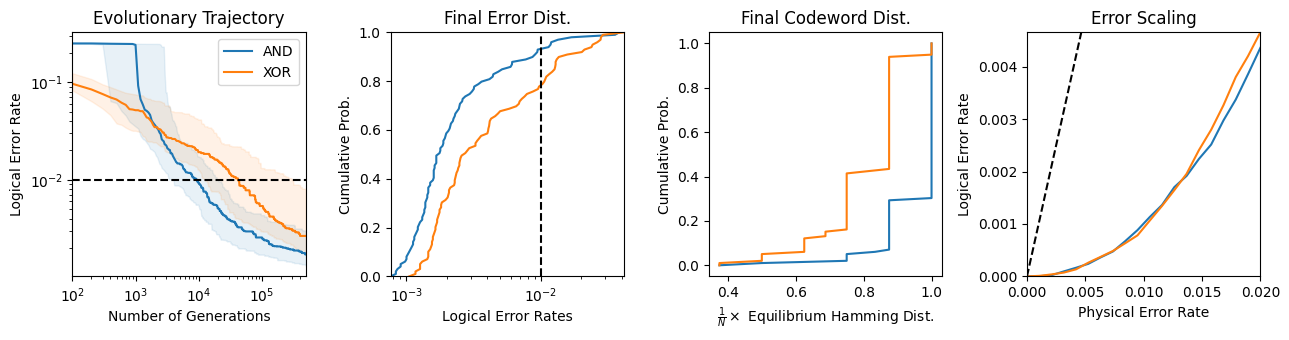

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3.5))
axs[0].plot(and_timestamps, and_median, color="C0", label="AND")
axs[0].fill_between(and_timestamps, [x[0] for x in and_bands], [x[1] for x in and_bands], alpha=0.1, color="C0")

axs[0].plot(xor_timestamps, xor_median, color="C1", label="XOR")
axs[0].fill_between(xor_timestamps, [x[0] for x in xor_bands], [x[1] for x in xor_bands], alpha=0.1, color="C1")
axs[0].set_yscale("log")
axs[0].set_xscale("log")

axs[0].set_ylabel("Logical Error Rate")
axs[0].set_xlabel("Number of Generations")
all_timestamps = np.concatenate([and_timestamps, xor_timestamps])
xmin = np.min(all_timestamps)
xmax = np.max(all_timestamps)
axs[0].set_xlim([xmin, xmax])
axs[0,].legend()
axs[0].set_title("Evolutionary Trajectory")
axs[0].plot([xmin, xmax], [0.01, 0.01], color="black", linestyle="--")

axs[1].plot(and_errors, and_probs, color="C0")
axs[1].plot(xor_errors, xor_probs, color="C1")
all_error_rates = np.concatenate([and_errors, xor_errors])
axs[1].set_xlim([np.min(all_error_rates), np.max(all_error_rates)])
axs[1].set_xscale("log")
axs[1].set_xlabel("Logical Error Rates")
axs[1].set_ylabel("Cumulative Prob.")
axs[1].set_ylim([0, 1])
axs[1].set_title("Final Error Dist.")
axs[1].plot([0.01, 0.01], [0, 1], color="black", linestyle="--")

axs[2].plot(sorted_and_dists/8, and_dist_probs, color="C0")
axs[2].plot(sorted_xor_dists/8, xor_dist_probs, color="C1")
axs[2].set_xlabel(r"$\frac{1}{N} \times$ Equilibrium Hamming Dist.")
axs[2].set_ylabel("Cumulative Prob.")
axs[2].set_title("Final Codeword Dist.")

axs[3].plot(physical_error_rates, and_logical_error_rates, color="C0")
axs[3].plot(physical_error_rates, xor_logical_error_rates, color="C1")
axs[3].plot(physical_error_rates, physical_error_rates, linestyle="--", color="black")
axs[3].set_xlim([np.min(physical_error_rates), np.max(physical_error_rates)])
axs[3].set_ylim([np.min(xor_logical_error_rates), np.max(xor_logical_error_rates)])
axs[3].set_xlabel("Physical Error Rate")
axs[3].set_ylabel("Logical Error Rate")
axs[3].set_title("Error Scaling")
fig.tight_layout()


In [ ]:
and_states, and_noise = analysis_util.run_dynamics_forward_save_state(batched_input_state, best_and_function, best_and_connectivity, best_and_used_connectivity, 10, 0.04)
and_noise = np.pad(and_noise, ((1, 1), (0, 0), (0,0), (0,0), (0,0)))

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True, figsize=(8,3))
lw = 0.3
cm = "Greys"
edgecolor="black"
axs[0, 0].pcolor(and_states[:, 0, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)
axs[0, 1].pcolor(and_states[:, 1, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)
axs[0, 2].pcolor(and_states[:, 2, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)
axs[0, 3].pcolor(and_states[:, 3, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)

axs[1, 0].pcolor(and_noise[:, 0, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)
axs[1, 1].pcolor(and_noise[:, 1, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)
axs[1, 2].pcolor(and_noise[:, 2, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)
axs[1, 3].pcolor(and_noise[:, 3, 0,0, :], cmap=cm, linewidth=lw, edgecolors=edgecolor)

axs[0, 0].set_ylabel("State vs time")
axs[1, 0].set_ylabel("Noise vs time")

[axs[1, i].set_xlabel("Node") for i in range(4)]

axs[0, 0].set_title("Input: 00")
axs[0, 1].set_title("Input: 01")
axs[0, 2].set_title("Input: 10")
axs[0, 3].set_title("Input: 11")

fig.tight_layout()

In [ ]:
g = general_network_visualization.influence_graph_from_ragged_spec(np.squeeze(best_and_function), np.squeeze(best_and_connectivity), np.squeeze(best_and_used_connectivity))
g.remove_nodes_from(list(nx.isolates(g)))
general_network_visualization.prune_non_participating(g, [0, 1, 2])
node_colors = ["C0"] * 8
node_colors[0] = "C1"
node_colors[1] = "C1"
node_colors[2] = "C2"


In [ ]:
pos = nx.spring_layout(g)
fig, axs = plt.subplots(figsize=(3,3))
general_network_visualization.plot_network_directed(g, pos, axs, node_colors[:len(g.nodes)], colorbar=False)

In [50]:
print(best_and_function[0, 0, 6, :])
print(best_and_connectivity[0,0,6,:])

[False False False  True False  True  True  True]
[0 3 1]
